In [1]:
#from dask import dataframe, delayed
#from dask.distributed import Client
import os
import re
import math
import time
import pandas as pd
import numpy as np
from IPython.display import display, clear_output
from sklearn import preprocessing, metrics, linear_model, metrics, svm, naive_bayes, tree

from sanitization_tools import *
#dataset_path = "/Users/juanzinser/Workspace/Tesis/data/kaggle/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
dataset_path = "census_level_0.csv"



In [2]:


ds_name="income"
y_col = "salary-class"
exclude_cols = ["lat", "lon", "hostel.name", "Distance"]
dataset_path = "census_level_0.csv"


def sanitize_df(df_path, ds_name, y_col, exclude_cols, cases):

    model_dict = dict()
    model_dict["linear_regression"] = linear_model.LinearRegression()
    model_dict["svm"] = svm.SVC(gamma=0.001, C=100.)
    model_dict["naive_bayes"] = naive_bayes.GaussianNB()
    model_dict["tree"] = tree.DecisionTreeRegressor()

    processed_cases = list()
    case_model_scores = dict()
    reco_list = list()
    
    iterator = 0
    for case in cases:

        if iterator > 0:
            privacy, include_real, uniform, uniform2, maybe = case[0], case[1], case[2], case[3], case[4]
            case_name = str(privacy)+("m" if maybe else "t" if include_real else "f") + ("t" if uniform else "f")+("t" if uniform2 else "f")
        else:
            # benchmark
            privacy, include_real, uniform, uniform2, maybe = 0, True, True, True, False
            case_name = "0.0ttt"
        print(case_name)
        if case_name not in processed_cases:
            for rand_num in range(10):
                case_name_rand = case_name +"_"+ str(rand_num)
                display(case_name_rand)

                data = pd.read_csv(dataset_path)#.sample()
                data = data.sample(int(len(data)/2))
                data = data.dropna()
                data = data[[col for col in data.columns if col not in exclude_cols]]
                data_cols = data.columns
                data_y = data[y_col]

                # selects categorical data
                std_cols = list(set(data.select_dtypes(["number"]).columns).difference({y_col}))
                for col in std_cols:
                    data[col] = pd.cut(data[col], bins=10, labels=False).map(str)
                cat_columns = list(set(data.select_dtypes(["bool_", "object_","flexible"],["number"]).columns).difference({y_col}))

                if iterator > 0:
                    meta_info = get_meta_info_pandas(data, cat_columns, privacy, include_real, uniform, uniform2, maybe, False)
                else:
                    meta_info = get_meta_info_pandas(data, cat_columns, privacy, include_real, uniform, uniform2, maybe, True)

                asd = {}
                rmse_dict = {}
                for col in cat_columns:
                    if len(meta_info["columns"][col]["counter"])<50:
                        asd[col] = np.matrix([entry_sanitization_with_maybe(entry=x, **meta_info["algorithm"], **meta_info["columns"][col]) for x in data[col]])
                        rmse_dict[col] = sum([np.power(x-y,2) for x,y in zip(meta_info["columns"][col]["counter"].values(), asd[col].sum(axis=0))])
                nis = pd.DataFrame.from_dict(rmse_dict, orient="index").reset_index()
                nis.columns = ["class", "rmse"]
                nis["case"] = case_name_rand
                reco_list.append(nis)

                dataa =  pd.concat([pd.DataFrame(v, columns=[k+"/"+i for i in meta_info["columns"][k]["key_to_order"].keys()]) for k, v in asd.items()], axis=1)
                if len(data_y.unique())==2:
                    dataa["y"] = (data_y==data_y.unique()[0]).astype(int).values
                else: # in case there is numeric take the median
                    dataa["y"] = (data_y>=sorted(data_y)[int(len(data_y)/2)]).astype(int).values
                dataa = dataa.dropna()
                display(dataa.head())
                case_model_scores[case_name_rand] = dict()
                for model_name, model in model_dict.items():
                    try:
                        case_model_scores[case_name_rand][model_name] = get_auc_score_of_model(dataa, model)#[:2]
                    except exception as e:
                        print(e)
                    display(model_name + str(case_model_scores[case_name_rand][model_name][:2]))
                clear_output(wait=True)
            processed_cases.append(case_name)
            iterator += 1

    reco_df = pd.concat(reco_list)
    reco_df.to_csv("supervised_rmse_df_"+ds_name+"011.csv")

    df_models_scores = pd.DataFrame.from_dict(case_model_scores, orient="index").reset_index().rename(columns={"index":"case"})
    df_models_scores = df_models_scores.melt(id_vars=df_models_scores.columns[0], value_vars=df_models_scores.columns[1:], value_name="models")
    df_models_scores = pn.DataFrame.from_dict(case_model_scores, orient="index").reset_index().rename(columns={"index":"case"})
    df_models_scores = df_models_scores.melt(id_vars=["case"]).rename(columns={"variable":"model"})


    df_models_scores["privacy"] = df_models_scores["case"].map(lambda x: int("".join(re.findall("\d+", x)[:2])))
    df_models_scores["real"] = df_models_scores["case"].map(lambda x: re.findall("[^\d]",x)[1])
    df_models_scores["uniform"] = df_models_scores["case"].map(lambda x: int(re.findall("[^\d]",x)[2] == "t"))
    df_models_scores["uniform2"] = df_models_scores["case"].map(lambda x: int(re.findall("[^\d]",x)[3] == "t"))

    df_models_scores["error"] = df_models_scores["value"].map(lambda x: x[0])
    df_models_scores["auc"] = df_models_scores["value"].map(lambda x: x[1])

    def all_entries_vector(x):
        xs = ""
        for xi in x:
            xs += str(xi) + ","
        return xs[:-1]

    df_models_scores["roc_x"] = df_models_scores["value"].map(lambda x: all_entries_vector(x[2][0]))
    df_models_scores["roc_y"] = df_models_scores["value"].map(lambda x: all_entries_vector(x[2][1]))
    df_models = df_models_scores[["case", "model", "privacy", "real", "uniform", "uniform2", "error", "auc", "roc_x", "roc_y"]]
    df_models.columns = [["case", "model", "privacy", "real", "uniform", "uniform2", "error", "auc", "roc_x", "roc_y"]]
    df_models.to_csv("model_scores_roc_"+ds_name+"011.csv")

In [ ]:
cases = [[1, True, True, True, False]]
for pr in range(1,11):
    cases += [
[pr/10, False, True, True, False],
                  [pr/10, True, True, True, False],
                  [pr/10, False, True, True, True],
                  [pr/10, True, False, False, False],
                  [pr/10, False, False, False, False],
                  [pr/10, False, False, False, True]
             ]
ds_name="income"
y_col = "salary-class"
exclude_cols = ["lat", "lon", "hostel.name", "Distance"]
df_path = "census_level_0.csv"
sanitize_df(df_path, ds_name, y_col, exclude_cols, cases)

0.0ttt


'0.0ttt_0'

,education/7th-8th,education/1st-4th,education/11th,education/Assoc-voc,education/9th,education/10th,education/Bachelors,education/Doctorate,education/12th,education/5th-6th,...,native-country/Scotland,native-country/Poland,native-country/Guatemala,native-country/Laos,native-country/Yugoslavia,native-country/Taiwan,native-country/Puerto-Rico,native-country/Iran,native-country/India,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


'linear_regression(0.16692331382814907, 0.8851935274854931)'

'naive_bayes(0.6012012012012011, 0.5946703652261751)'

'tree(0.20036764705882348, 0.7787301403088114)'

In [9]:
data = pd.read_csv(dataset_path)

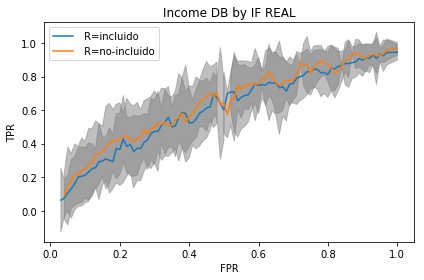

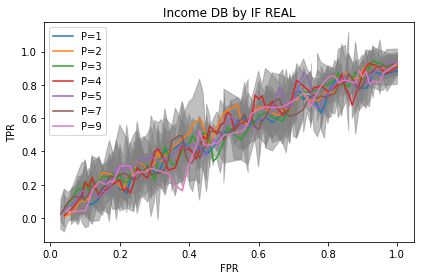

privacy
1     0.493430
2     0.514230
3     0.516208
4     0.510016
5     0.505912
6     0.490474
7     0.500592
8     0.492459
9     0.506370
10    0.500000
Name: auc, dtype: float64


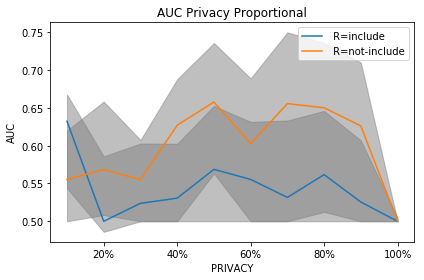

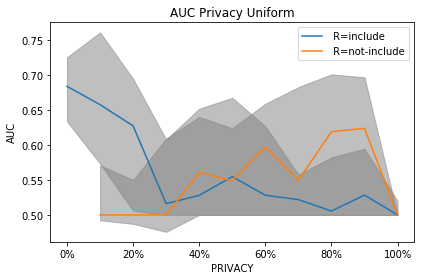

In [10]:

#supervised_results = pd.concat([pn.read_csv("model_scores_roc_census06_mbe.csv"), pd.read_csv("model_scores_roc_census611_mbe.csv")])
supervised_results = pd.read_csv("model_scores_roc_"+ds_name+"011.csv")
rocs_by_case(supervised_results, {},{"real":["t","f"]}, savefig=True, title="by IF REAL", save_name=ds_name+"_roc_privacy_grouped_tmf",language="spanish")
rocs_by_case(supervised_results, {"real":"m"},{"privacy":[1,2,3,4,5,7,9]}, savefig=True, title="by IF REAL", save_name=ds_name+"_roc_privacy_grouped_tmf",language="spanish")

print(supervised_results[supervised_results.real=="m"].groupby("privacy")["auc"].agg(lambda x:np.average(x)))


plot_intervals(supervised_results, "privacy","auc", {"uniform":[0], "uniform2":[0]}, 
               {"real":["t", "f"]}, savefig=True, 
               title="AUC Privacy Proportional", save_name=ds_name+"_auc_real_proportional")
plot_intervals(supervised_results, "privacy","auc", {"uniform":[1], "uniform2":[1]}, 
               {"real":["t", "f"]}, savefig=True, 
               title="AUC Privacy Uniform", save_name=ds_name+"_auc_real_uniform")